#0.0 Imports and Helper Functions


## 0.1 Imports

In [1]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.2 MB/s eta 0:00:00


In [2]:
!pip install inflection

In [3]:
!pip install boruta

In [4]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [5]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## 0.2 Helper Functions

In [6]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    sns.set(font_scale=1.6)

    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [8]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [9]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [10]:
def ml_cv_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    mm = MinMaxScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data


In [11]:
df1 = pd.read_csv('fraud_0.1origbase.csv')

In [12]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [13]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


## 1.2 Columns

**step:** Represents a unit of time in the real world, where 1 step is equivalent to 1 hour. There are a total of 744 steps, corresponding to a 30-day simulation.

**type:** Denotes the type of transaction, which can be CASH-IN, CASH-OUT, DEBIT, PAYMENT, or TRANSFER.
amount: Represents the amount of the transaction in the local currency.

**nameOrig:** Refers to the customer who initiated the transaction.

**oldbalanceOrg:** Indicates the initial balance of the origin account before the transaction.

**newbalanceOrig:** Represents the new balance of the origin account after the transaction.

**nameDest:** Refers to the customer who is the recipient of the transaction.

**oldbalanceDest:** Indicates the initial balance of the destination account before the transaction. Note that there is no information for accounts starting with "M" (Merchants).

**newbalanceDest:** Represents the new balance of the destination account after the transaction. Note that there is no information for accounts starting with "M" (Merchants).

**isFraud:** Indicates whether the transaction is fraudulent or not. Transactions made by fraudulent agents aim to profit by taking control of customer accounts and emptying the funds through transfers and cash-outs.

**isFlaggedFraud:** Denotes whether the transaction is flagged as illegal. In this dataset, an illegal attempt is defined as an attempt to transfer more than 200,000 in a single transaction.


### 1.2.2 Column Rename

In [14]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [15]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [16]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## 1.4 Data Types and Structure

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA


In [18]:
df1.isna().mean()

step                0.0
type                0.0
amount              0.0
name_orig           0.0
oldbalance_org      0.0
newbalance_orig     0.0
name_dest           0.0
oldbalance_dest     0.0
newbalance_dest     0.0
is_fraud            0.0
is_flagged_fraud    0.0
dtype: float64

## 1.6 Fill Out NA

There's no NaN values to fill.


## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [19]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## 1.8 Description Statistics

In [20]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [21]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


### 1.8.2 Categorical Attributes

In [22]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C334643493,C2083562754,no,no
freq,224216,2,14,635441,636260


# 2.0 Feature Engineering


In [23]:
df2 = df1.copy()

## 2.1 Mind Map

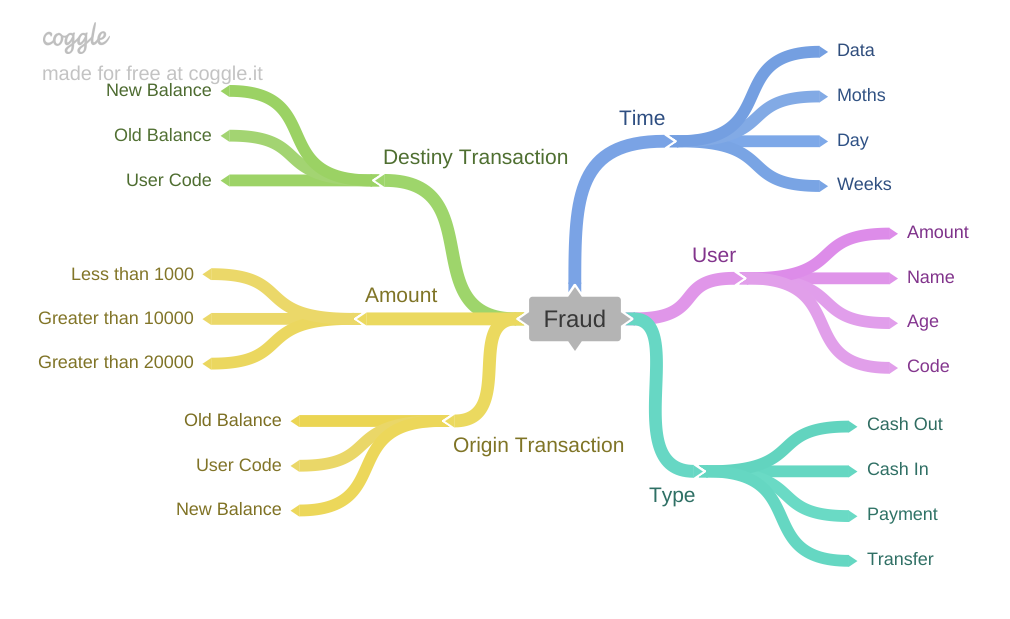

In [24]:
Image('mind-map.png')

## 2.2 Hypothesis Creation

### 2.2.1 User

* 90% of the twenty-one-year-old users did a fraud transaction.

  * This hypothesis suggests that a significant portion of users who are twenty-one years old are involved in fraud transactions.
  
* The majority of fraud transactions occur for users with the same initial letter.

  * This hypothesis proposes that there is a pattern where fraud transactions are more likely to occur among users with similar initials.

* All fraud transactions involve amounts greater than 10,000.

  * This hypothesis implies that fraud transactions typically involve large amounts of money.

* 60% of the users are older than 30 years old.

  * This hypothesis suggests that a significant portion of users involved in fraud transactions are over 30 years old.


### 2.2.2 Type


* 60% of fraud transactions occur using the cash-out type method.

  * This hypothesis suggests that a specific type of transaction method (cash-out) is more commonly associated with fraud.

* The majority of transfers occur using the transfer type method.

  * This hypothesis implies that most legitimate transactions involve the transfer type method.

* Fraudulent transactions with values greater than 100,000 occur using the transfer type method.

  * This hypothesis suggests a threshold value for fraudulent transactions occurring through the transfer method.

* Payment type transactions occur with values lower than 100,000.

  * This hypothesis implies that payment type transactions typically involve smaller amounts.

### 2.2.3 Origin and Destiny Transactions

* 60% of the difference between origin and destiny transactions is equal to 0 for frauds.

  * This hypothesis suggests a pattern where the difference between origin and destiny transactions is minimal for fraudulent transactions.

* Origin values are greater than destiny values for fraud transactions.

  * This hypothesis implies that fraudulent transactions involve transferring money from accounts with higher balances to accounts with lower balances.

### 2.2.4 Time

* Fraud transactions occur at least over a period of 3 days.
  * This hypothesis suggests that fraudulent activities persist over multiple days.

* 40% of cash-out transactions occur within less than 1 day.

  * This hypothesis implies that a significant portion of cash-out transactions are completed quickly.

* 60% of transactions with values less than 100,000 occur over at least 10 days.

  * This hypothesis suggests that transactions with smaller values typically take longer to complete.

* Transactions with values greater than 10,000 occur within a maximum period of 2 weeks.

  * This hypothesis implies a time constraint for transactions involving larger amounts.


## 2.3 Hypothesis List

1. The majority fraud transiction occours for the same initial letter user.

1. All the fraud amount is greater than 10.000.

1. 60% of fraud transaction occours using cash-out-type method.

1. The majority transfers occours using tranfers-type method.

1. Fraud transactions occours at least in 3 days.

## 2.4 Feature Engineering

In [25]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

# 3.0 Selecting Columns

In [26]:
df3 = df2.copy()

## 3.1 Selecting Columns

I'll use all the columns for data analysis

## 3.2 Selecting Rows

I'll use all the rows.

# 4.0 Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 4.1 Univariate Analysis


### 4.1.1 Response Variable

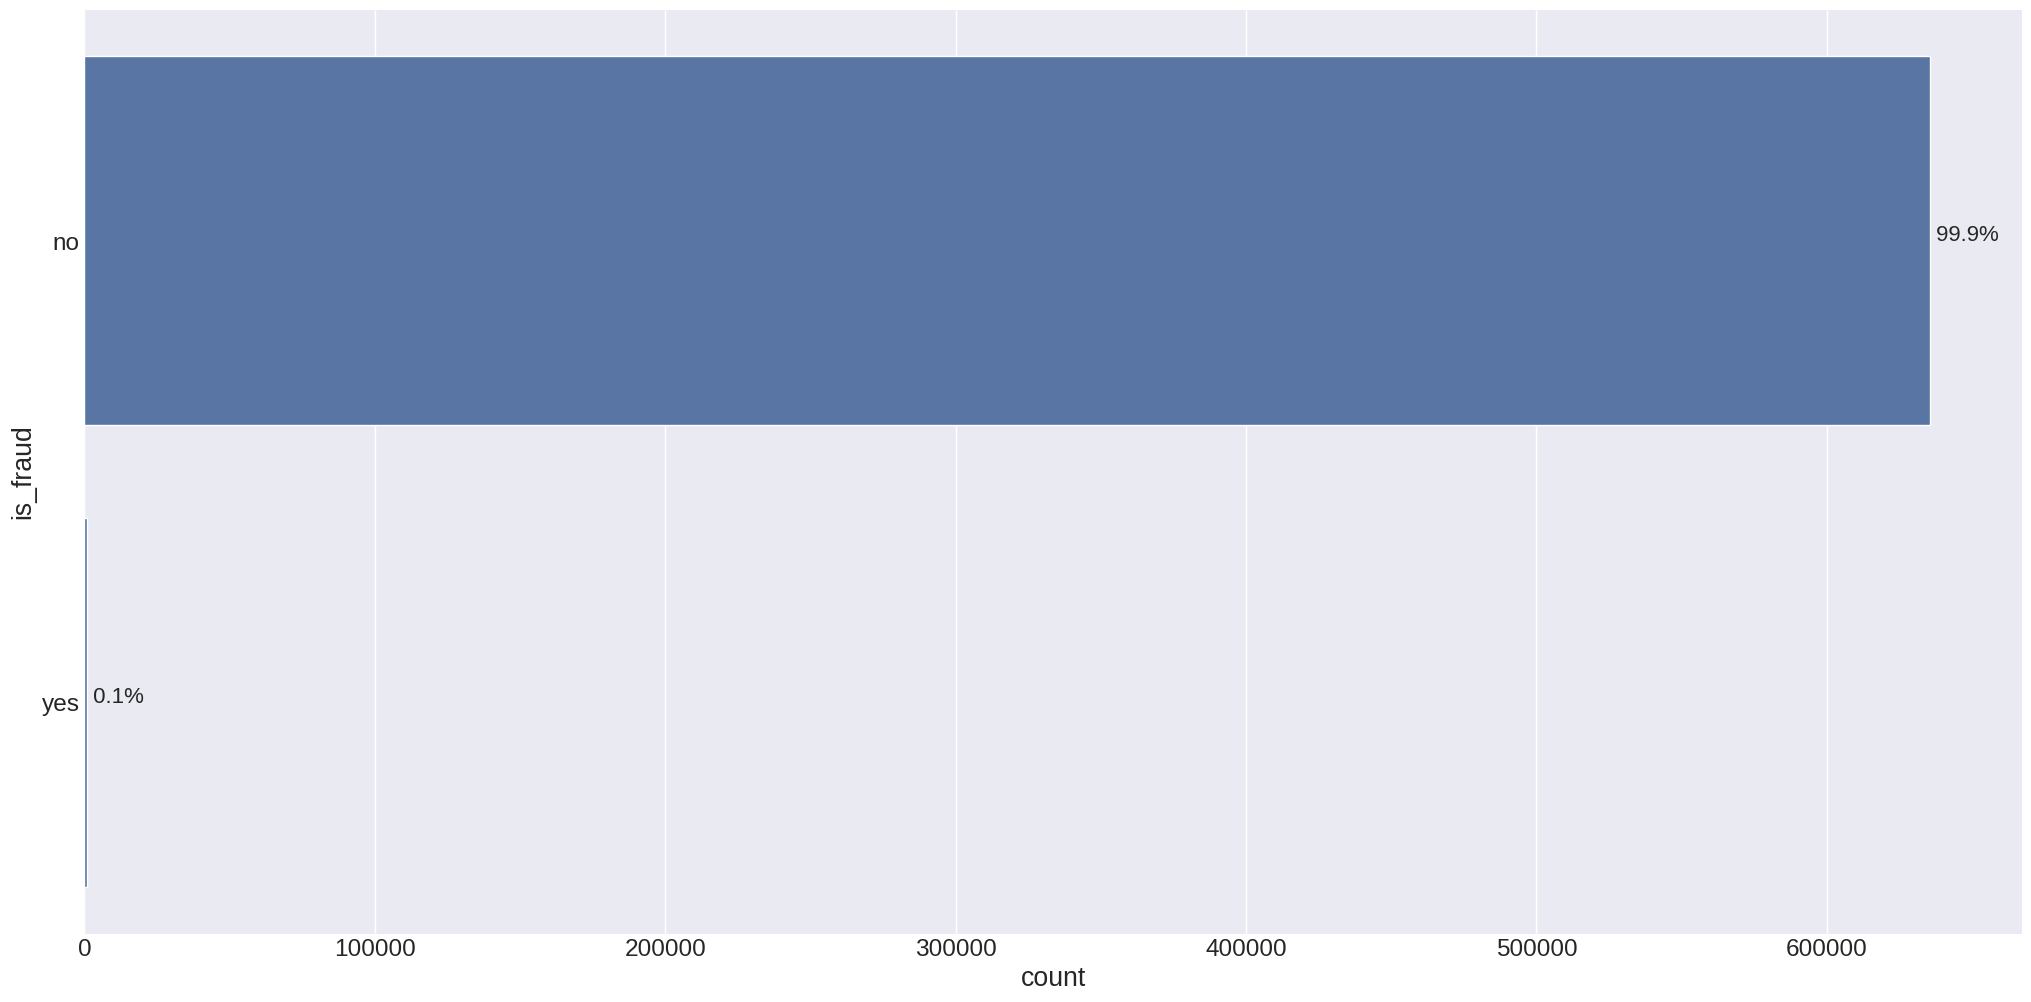

In [28]:
ax = sns.countplot(y='is_fraud', data=df4)

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

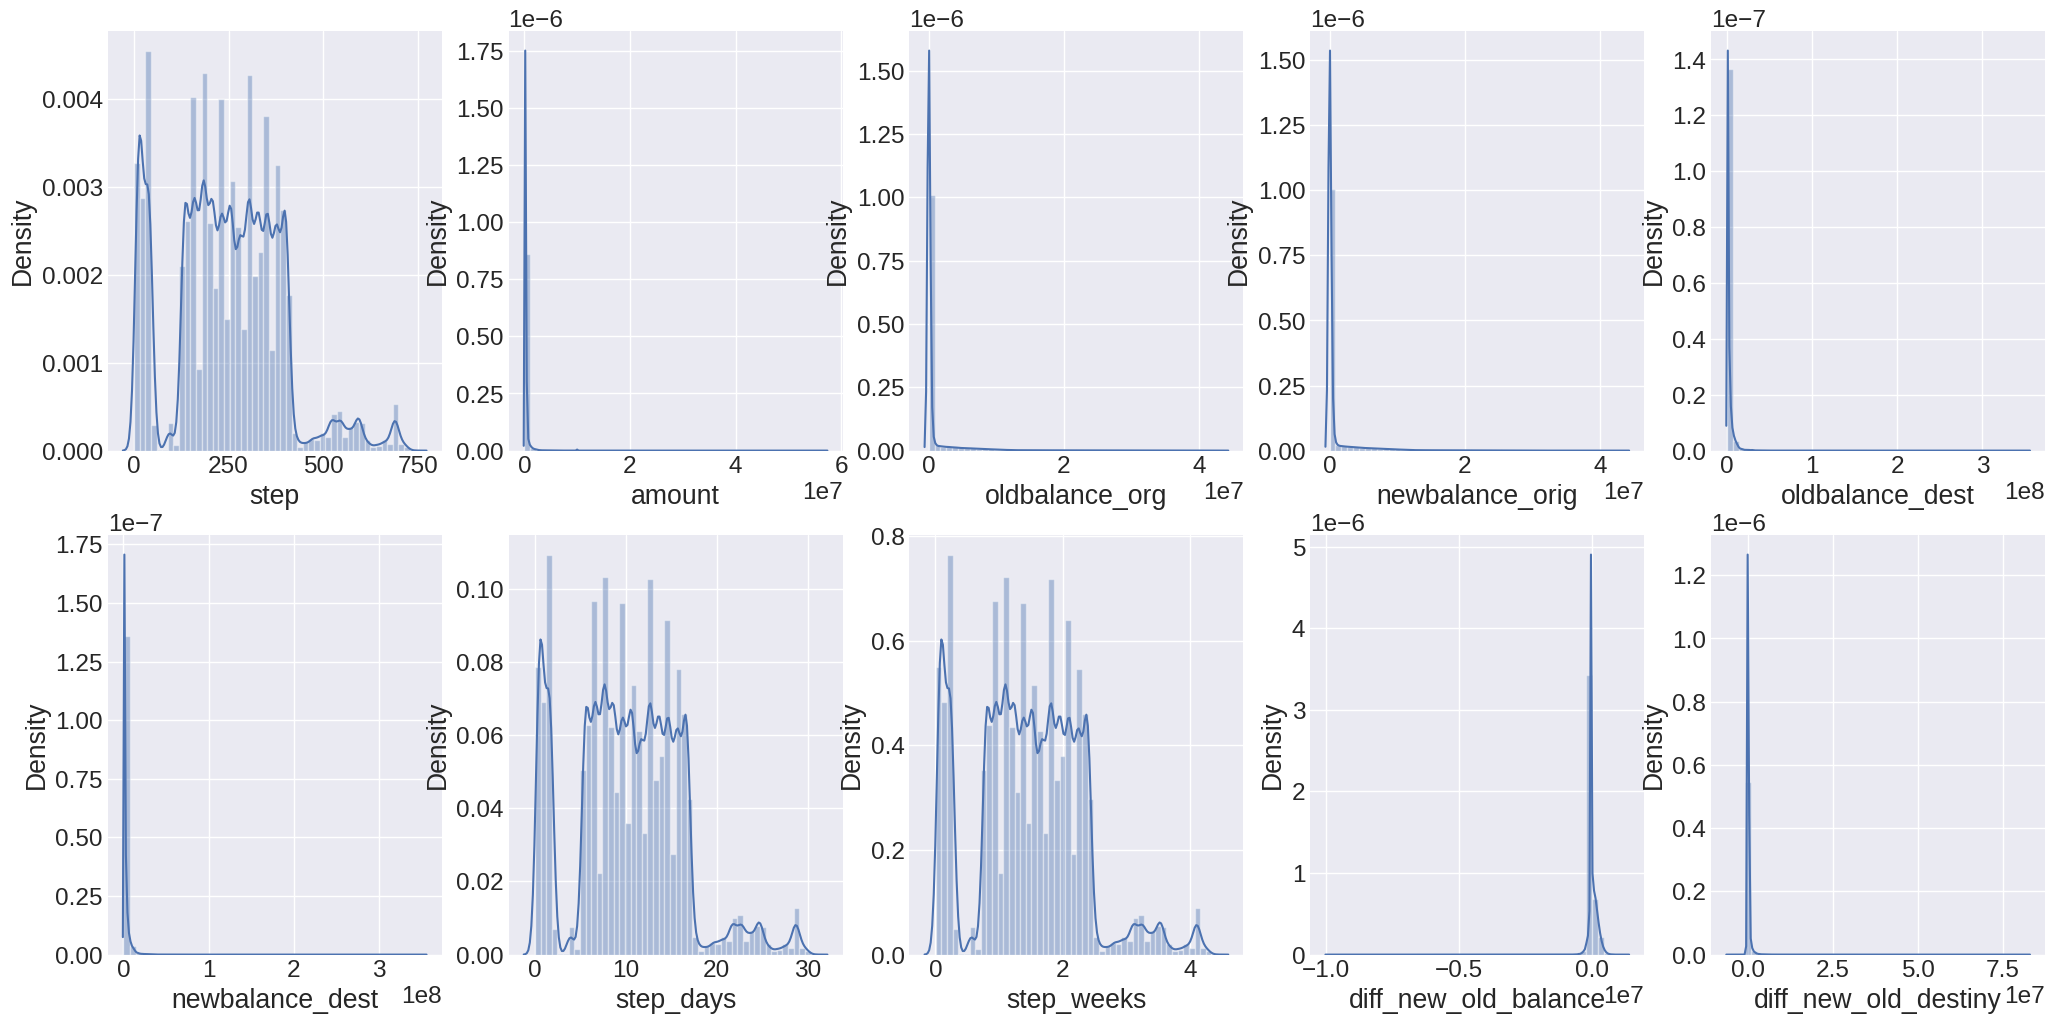

In [29]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);

    j += 1

### 4.1.3 Categorical Variables

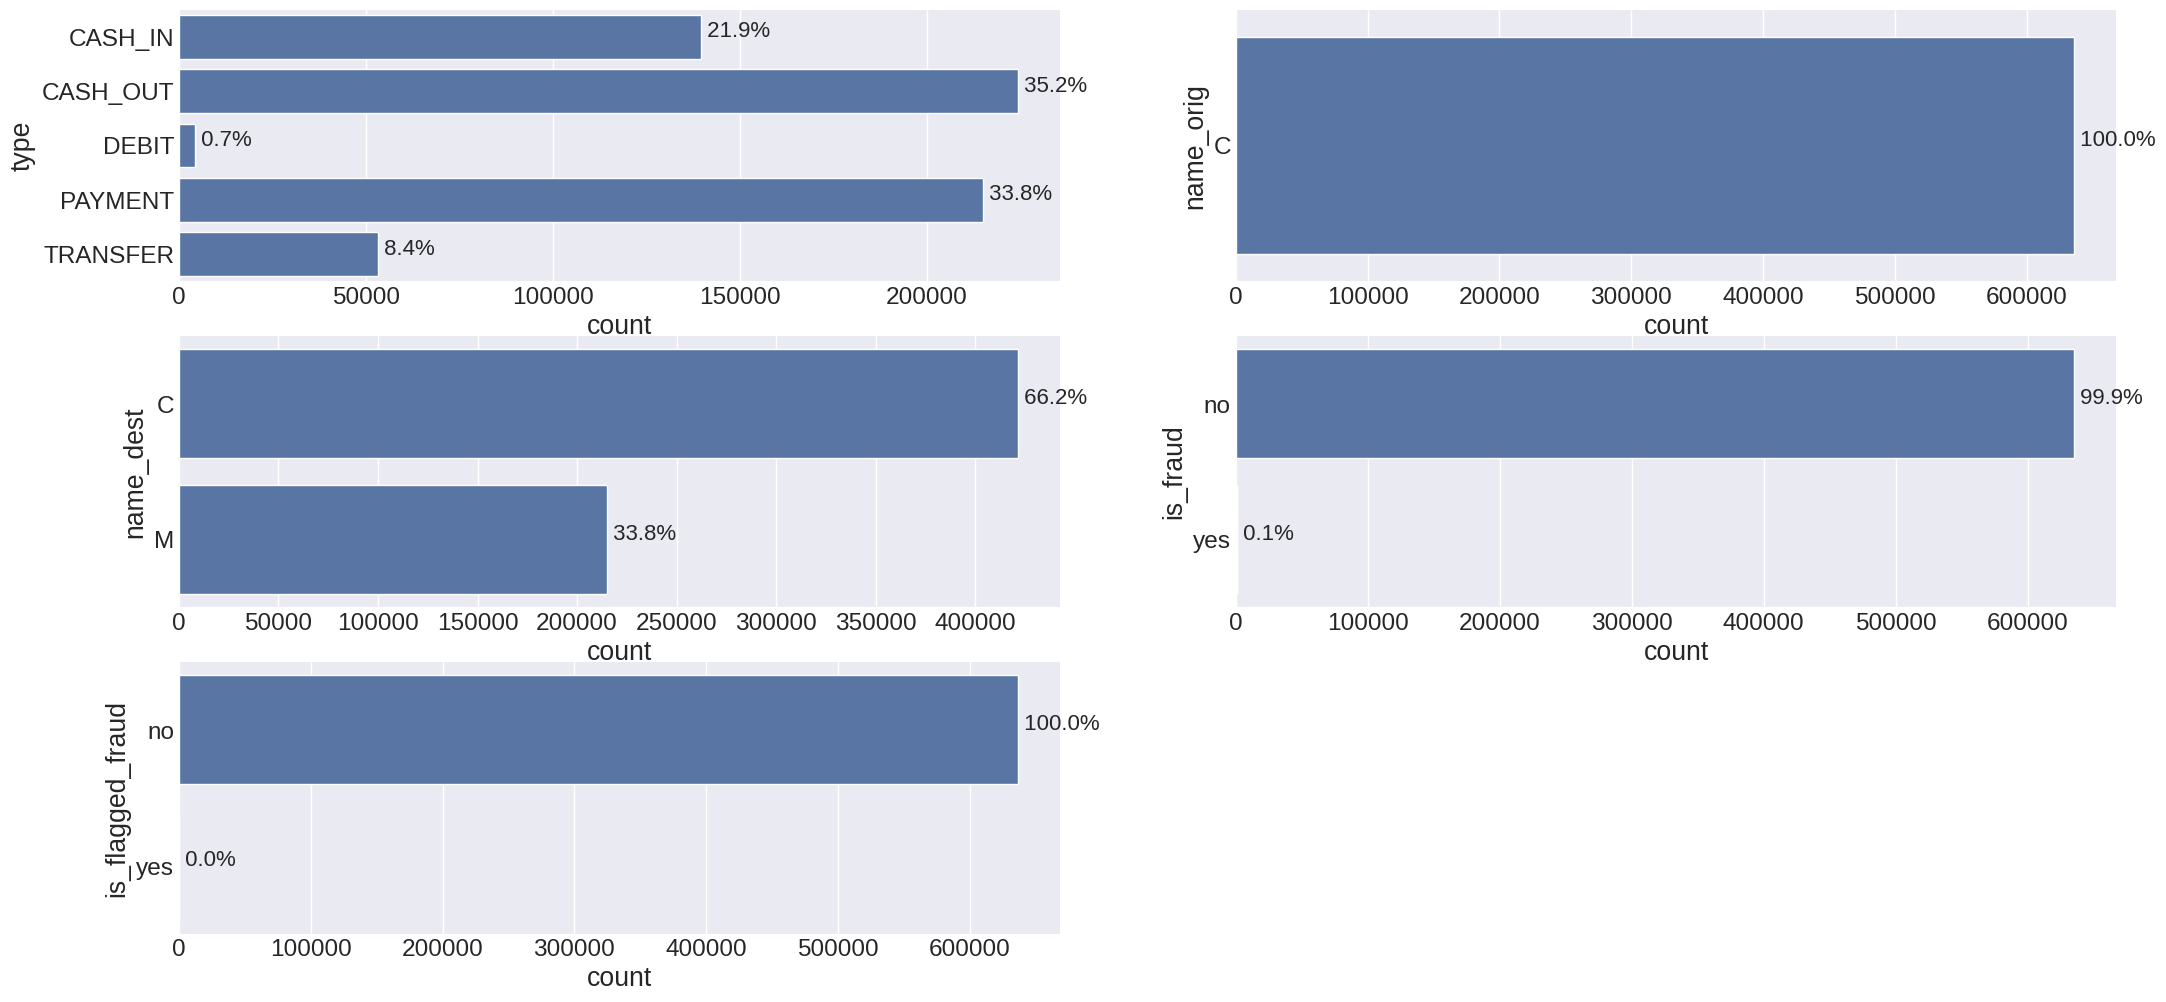

In [30]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)

    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    j += 1

## 4.2 Bivariate Analysis

### H1 The majority fraud transiction occours for the same user.
**TRUE:** The same user origem and destiny has got the same initial letter.

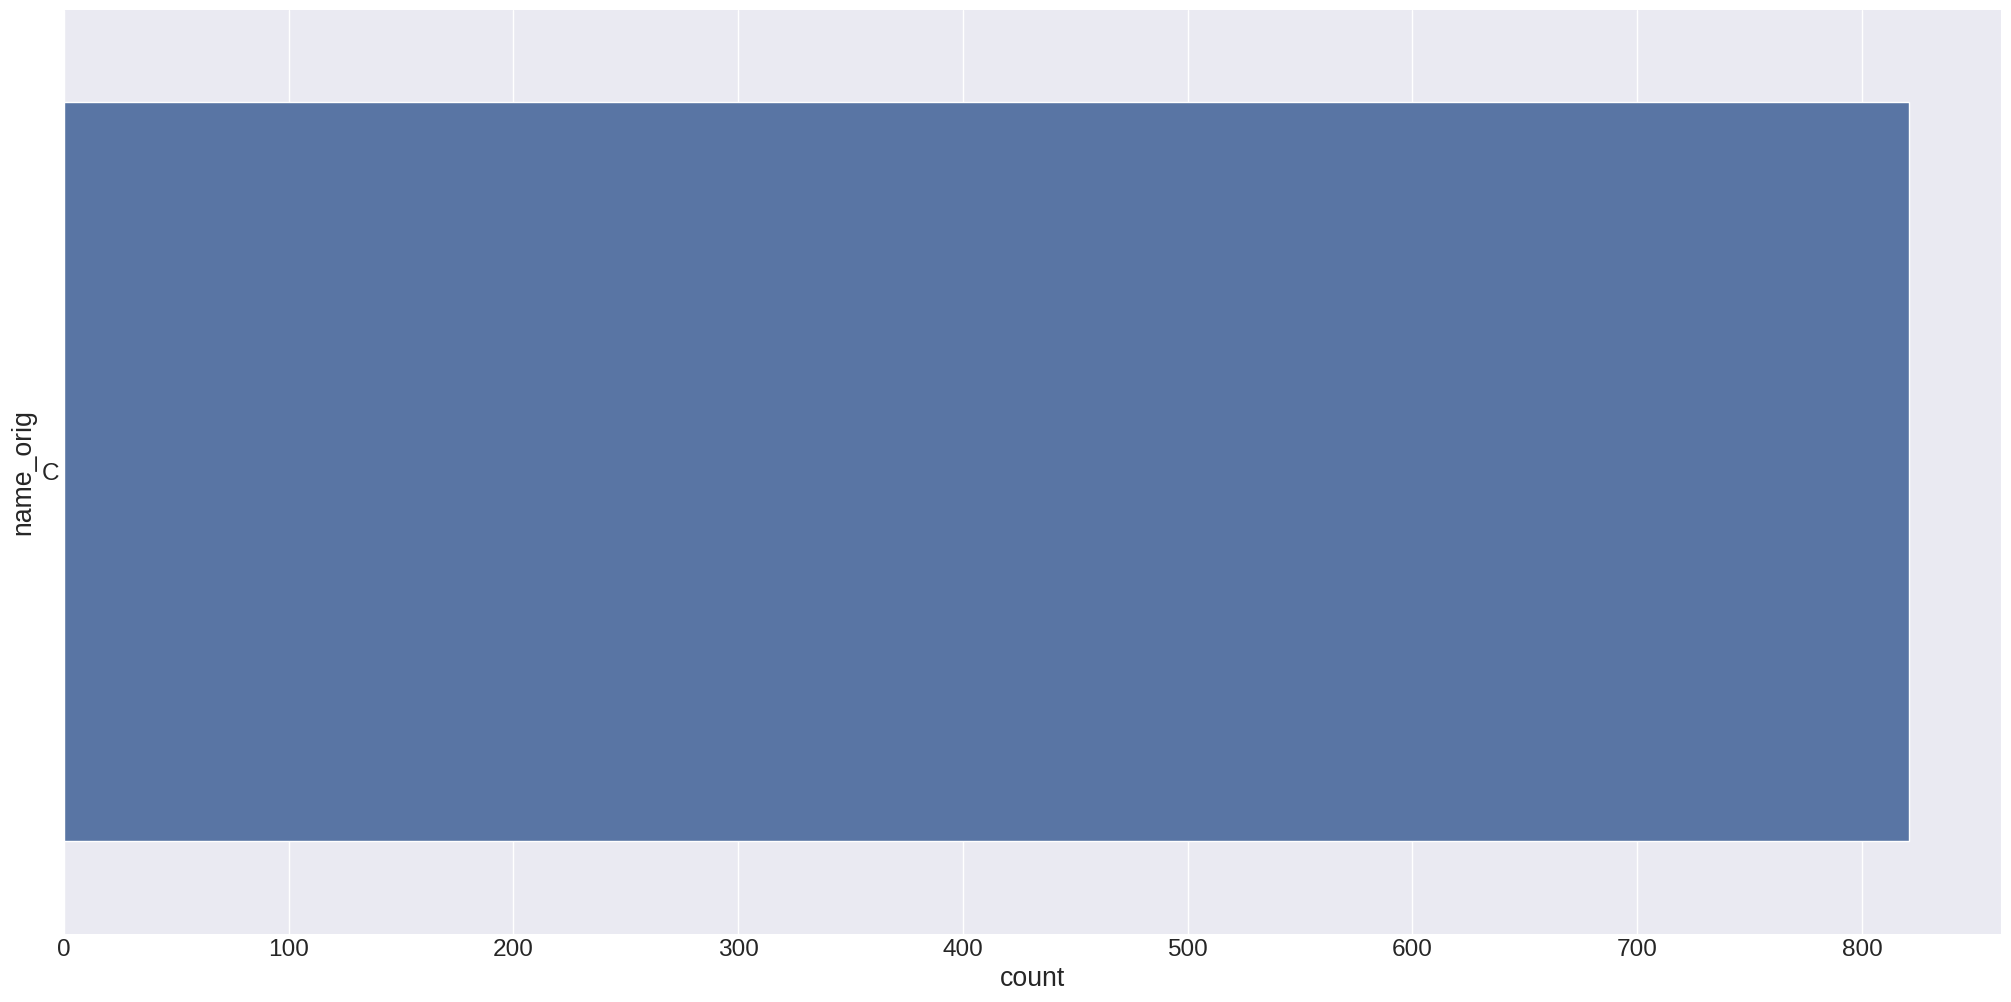

In [31]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

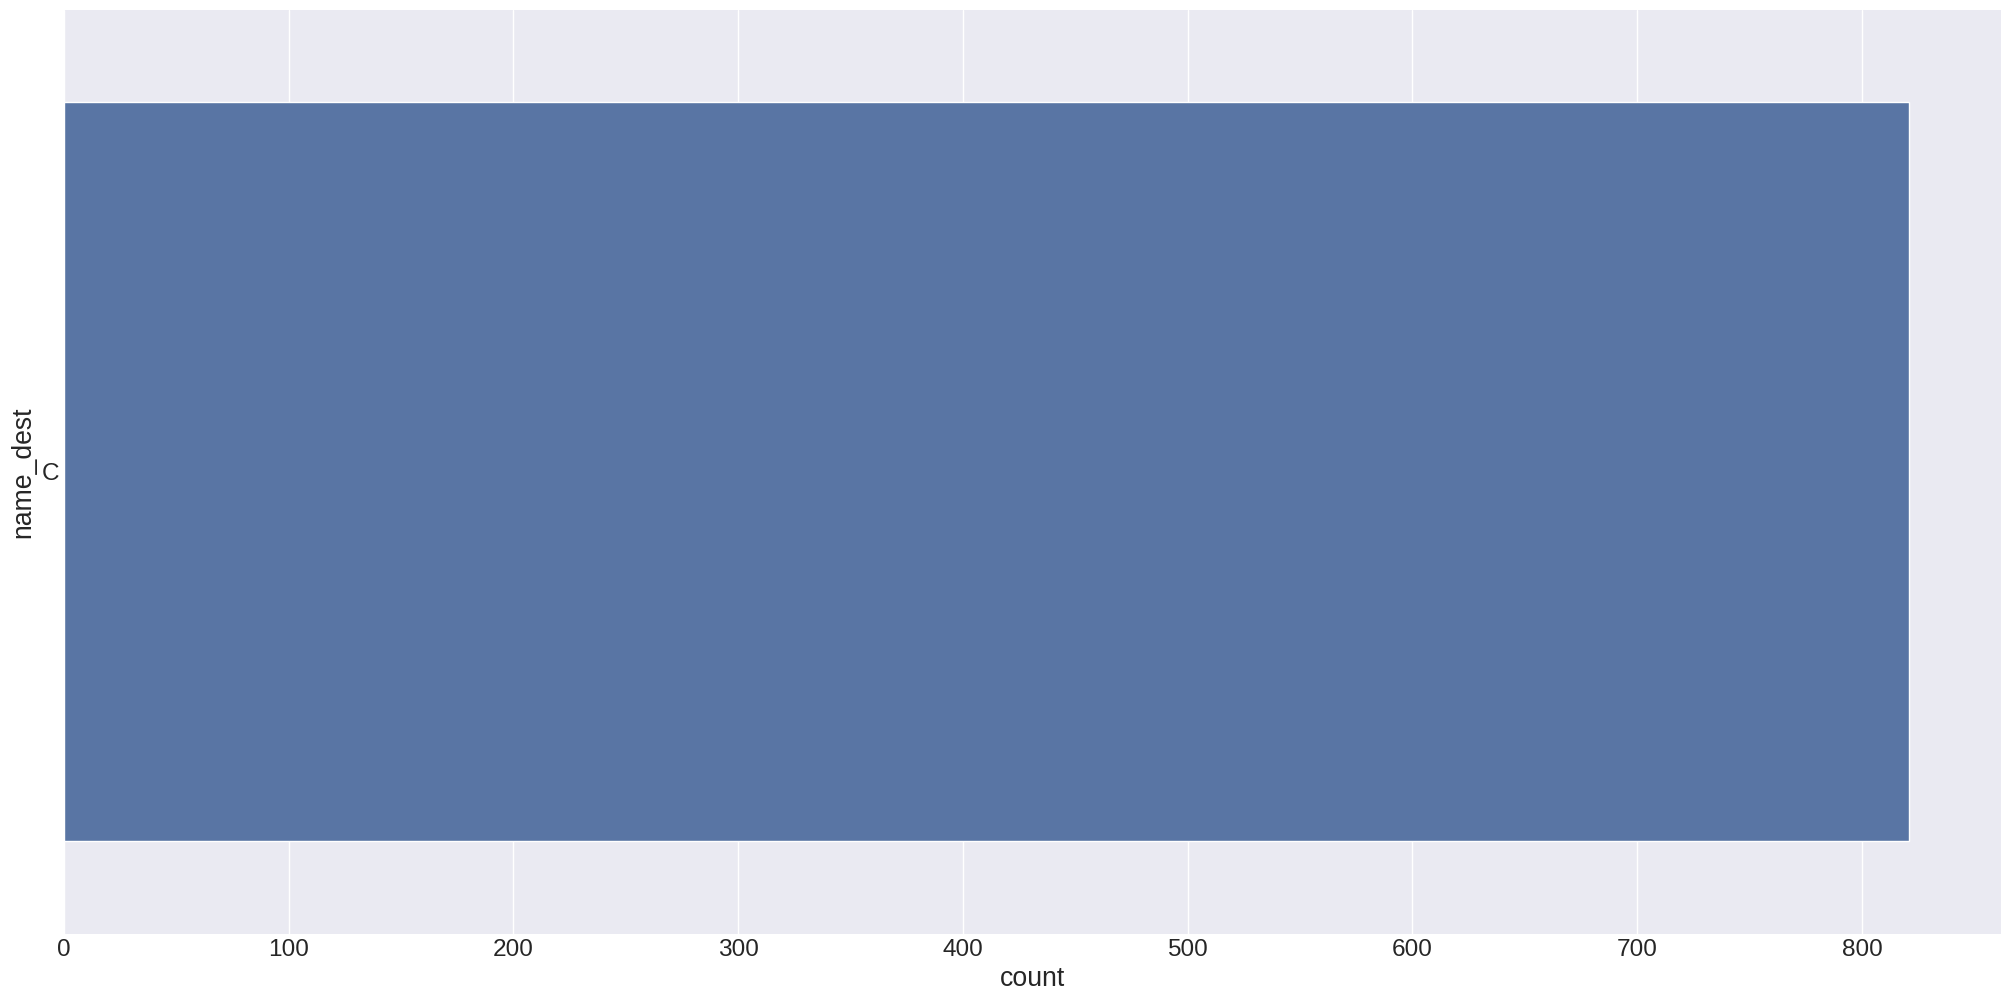

In [32]:
sns.countplot(y='name_dest', data=aux1);

### H2 All the fraud amount is greater than 10,000.

**TRUE:** The values are greater than 10,000. But it's important to note that the no-fraud values is greater than 100,000 also.

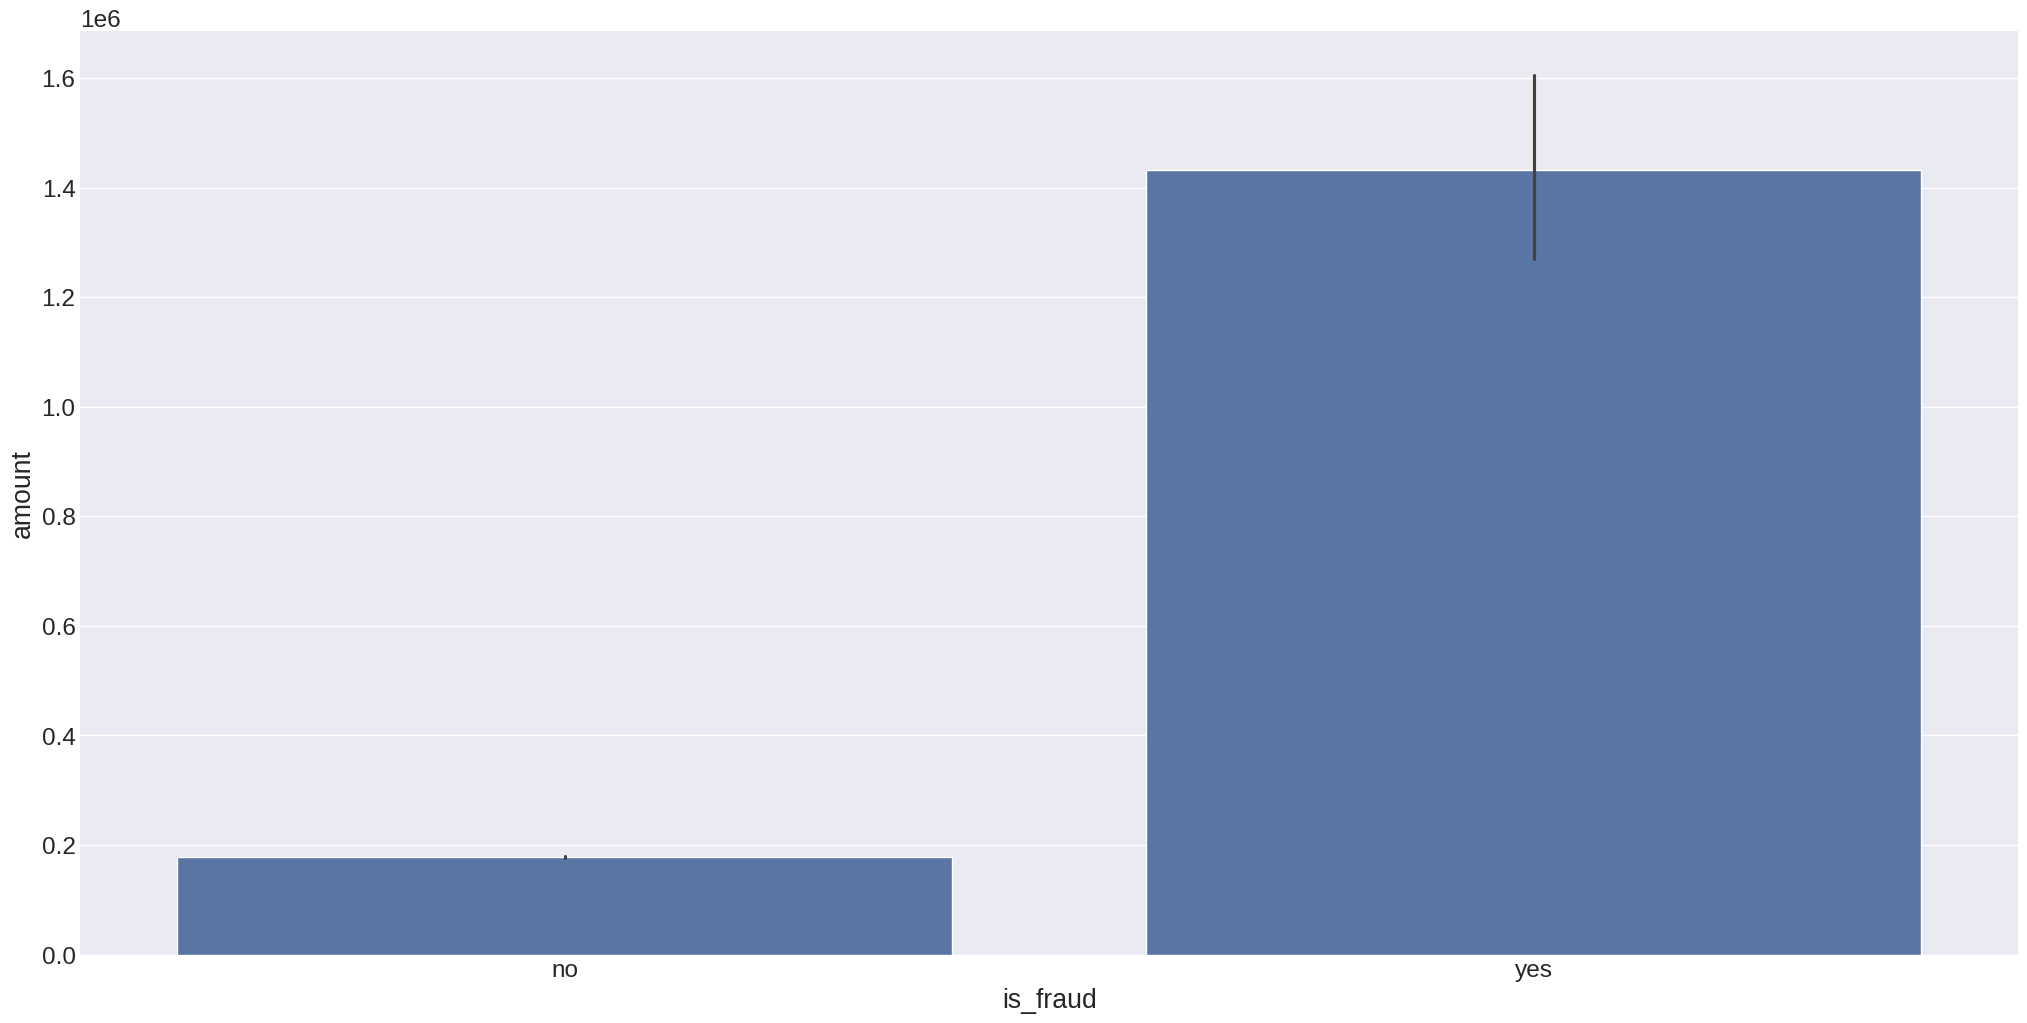

In [33]:
sns.barplot(y='amount', x='is_fraud', data=df4);

### H3 60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

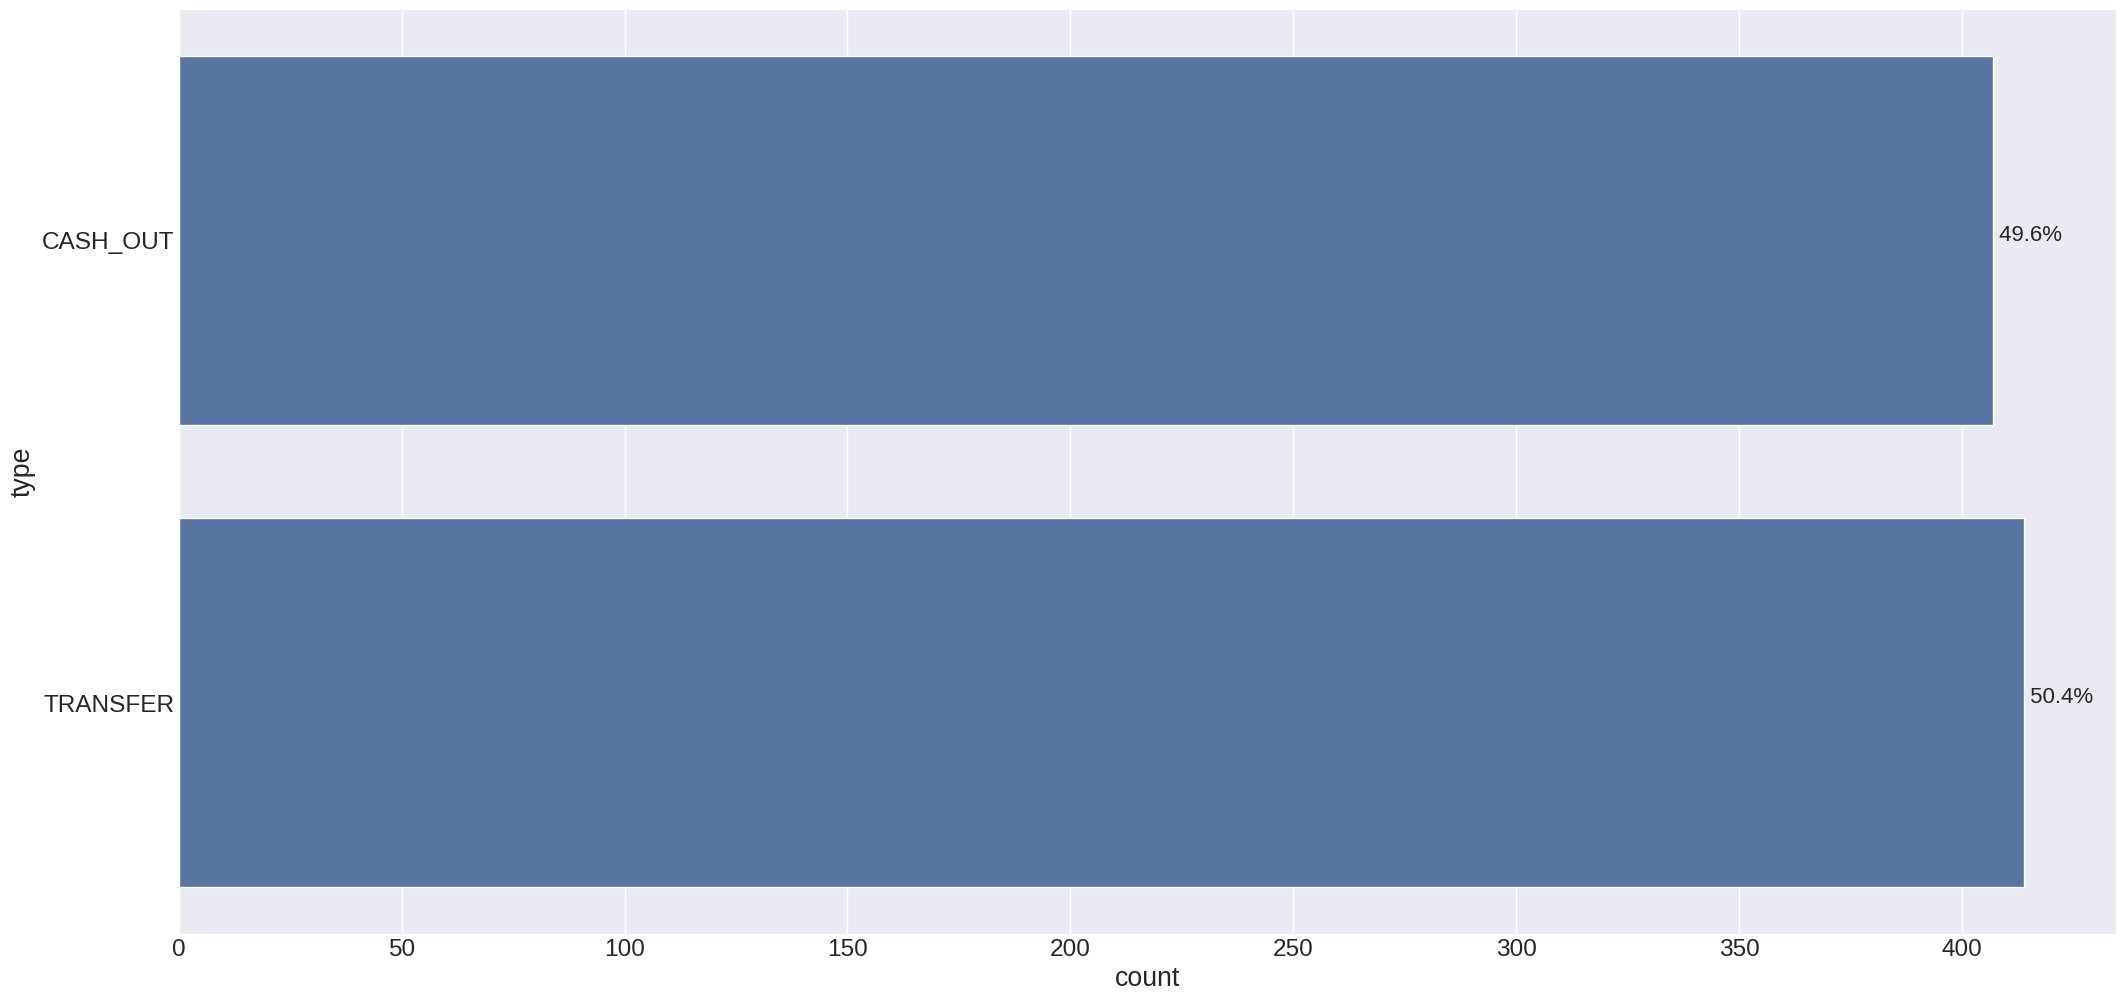

In [34]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

To see the complete transaction-type and I'll plot them here.

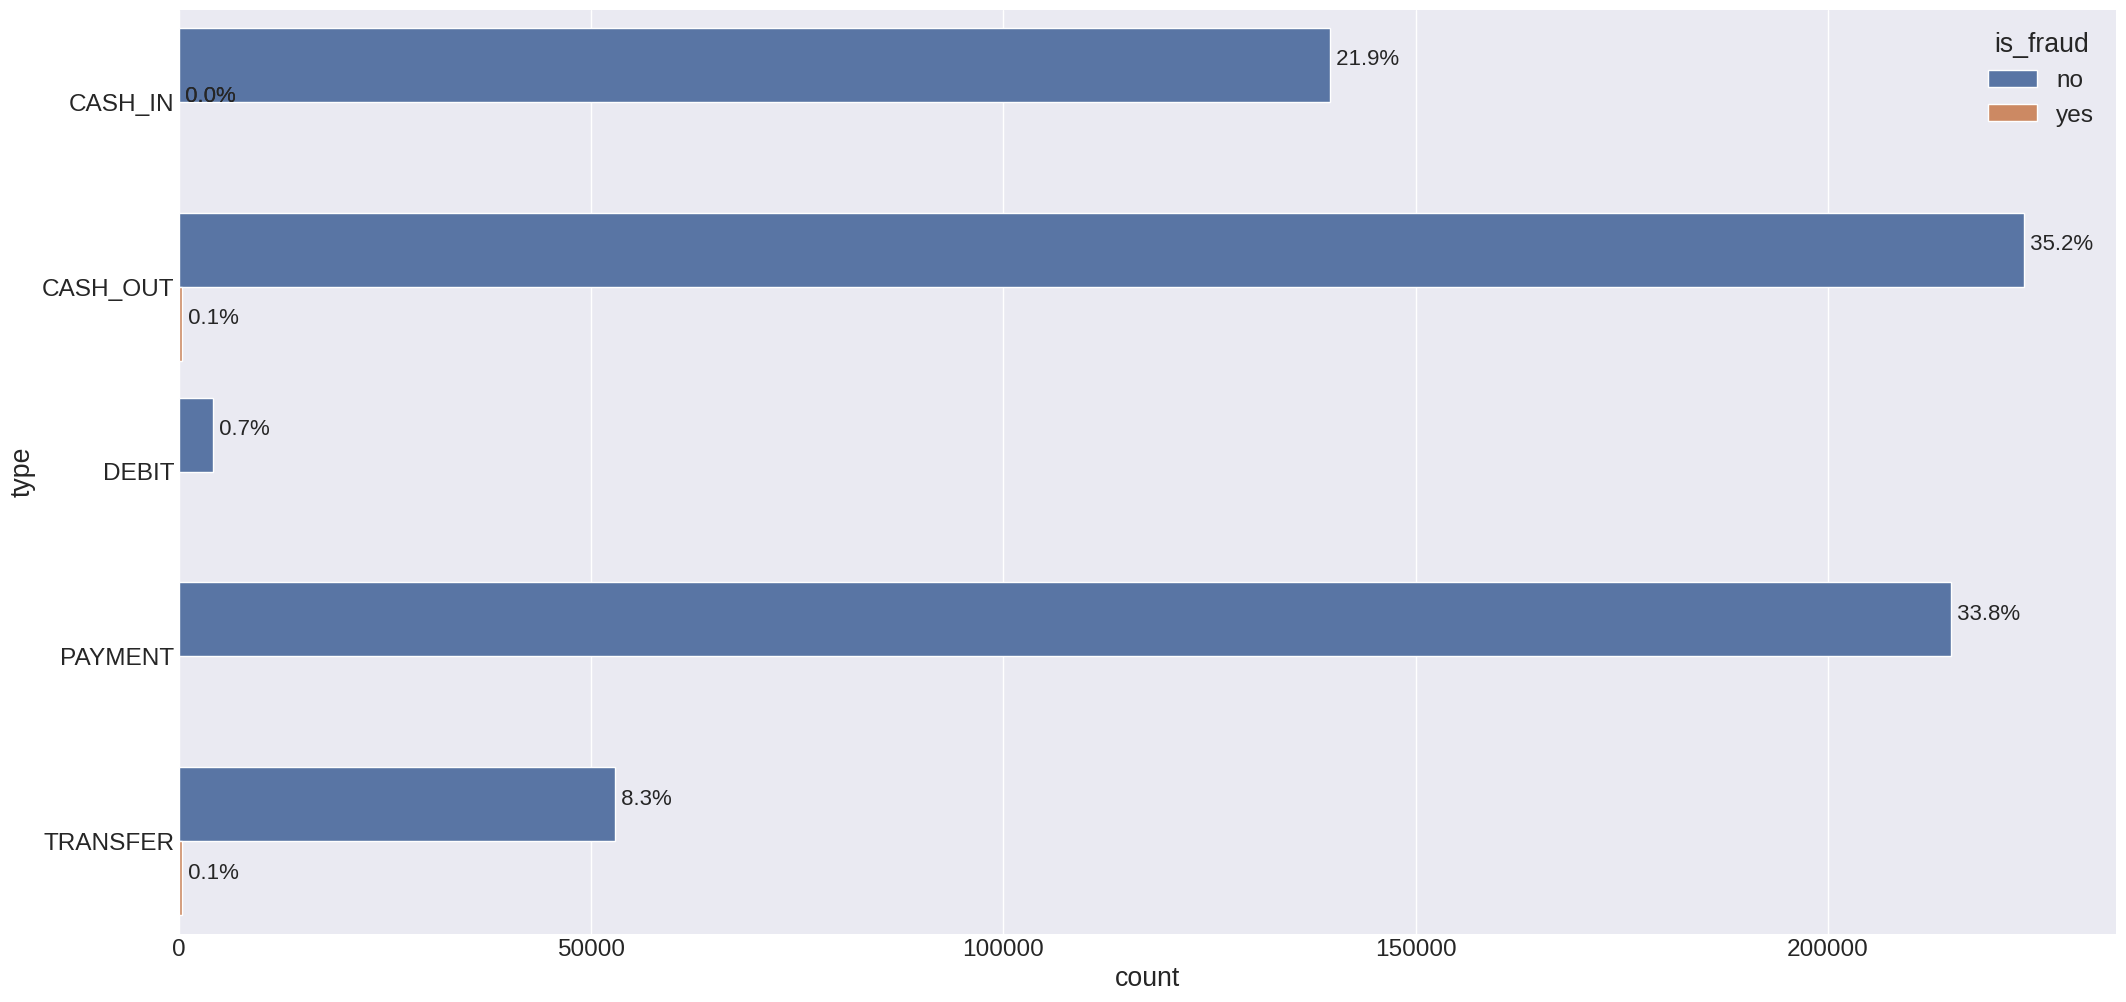

In [35]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H4 Values greater than 100,000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100,000 occour in cash-out and cash-in too.

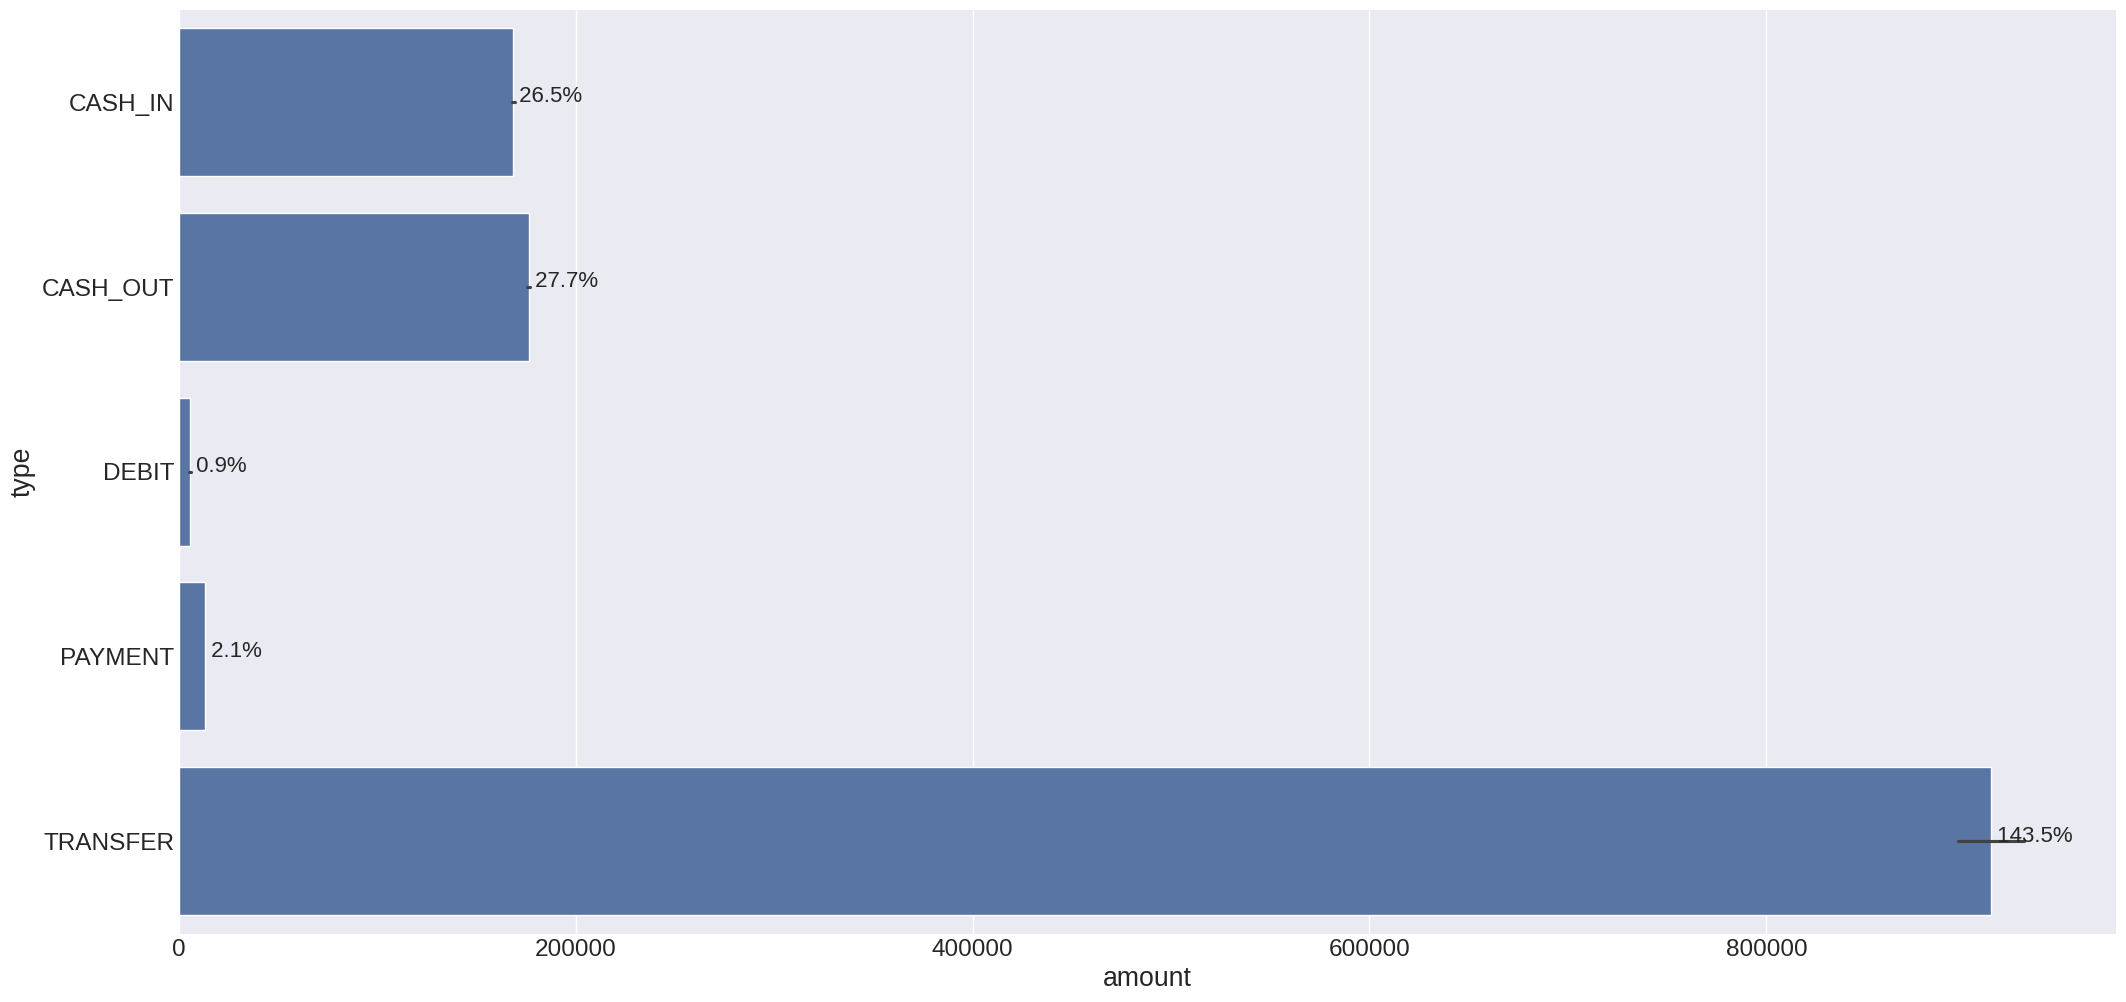

In [36]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

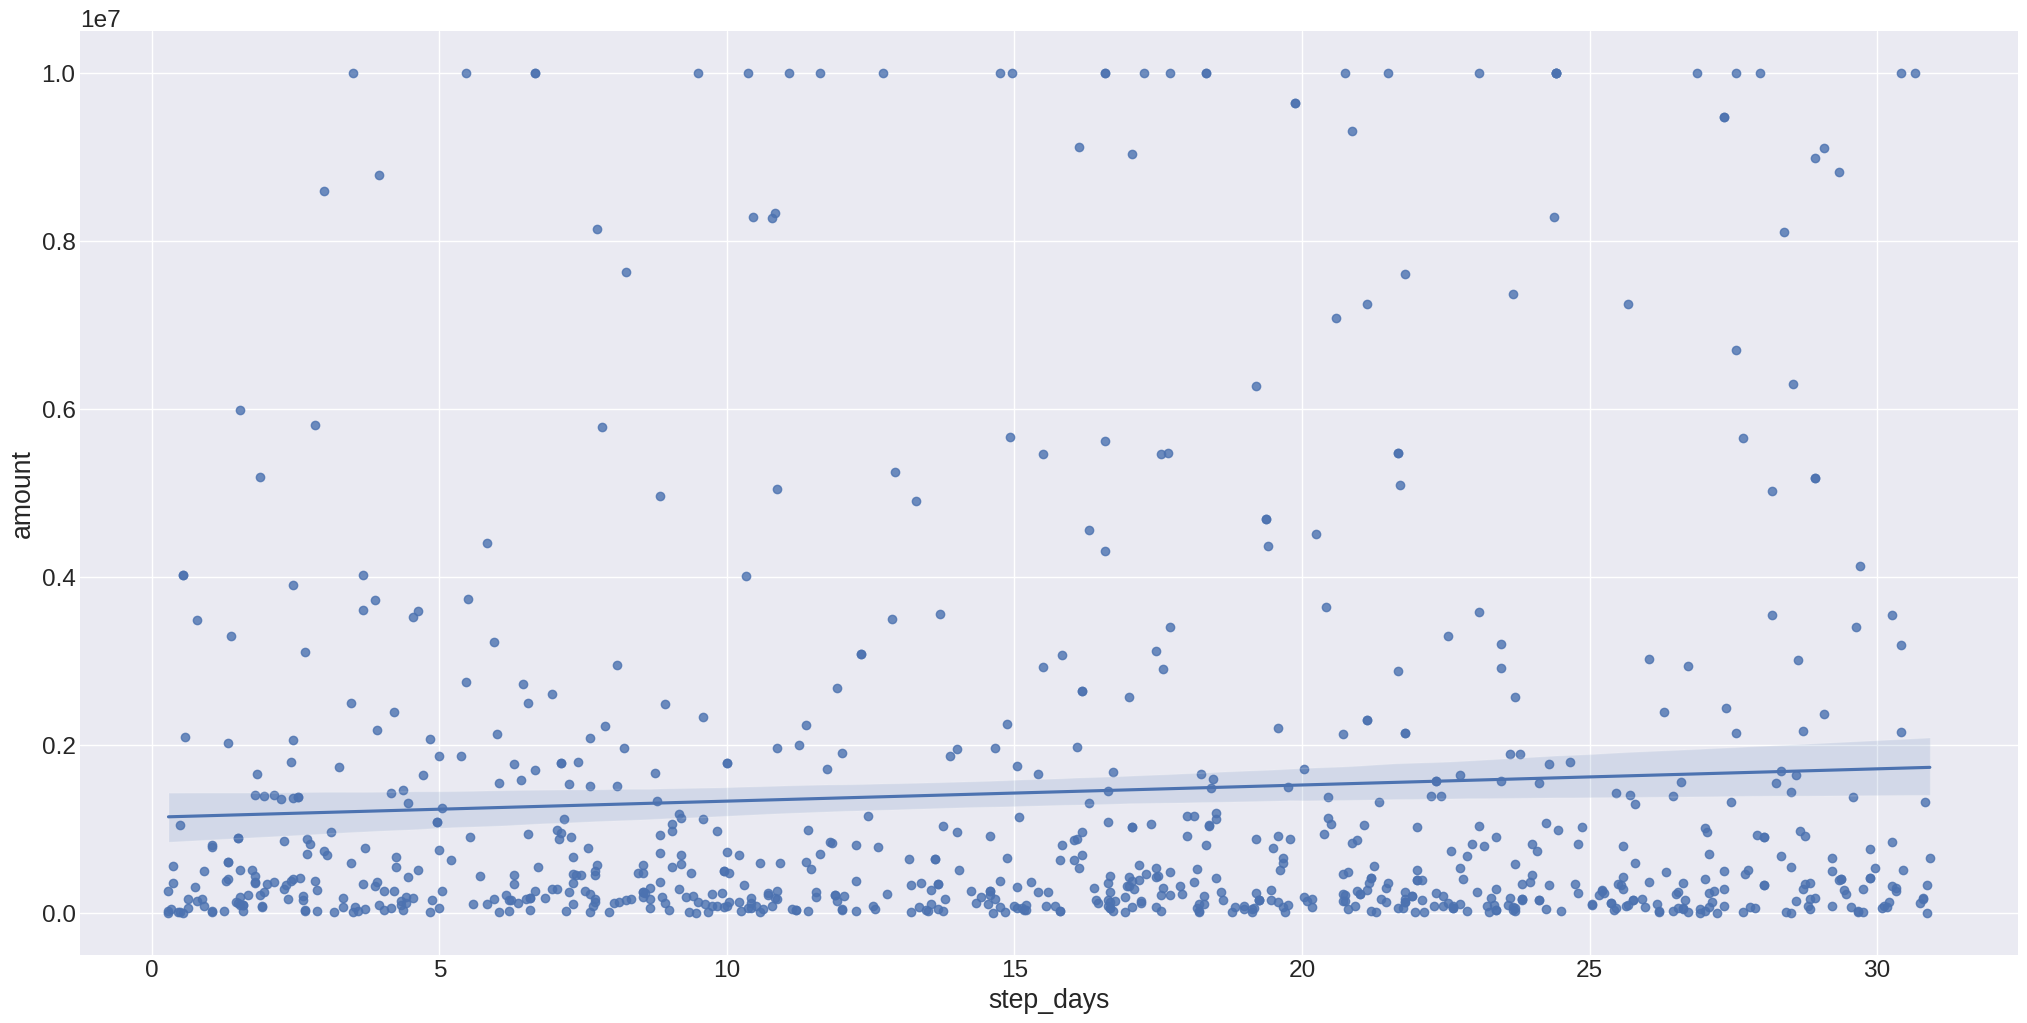

In [37]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

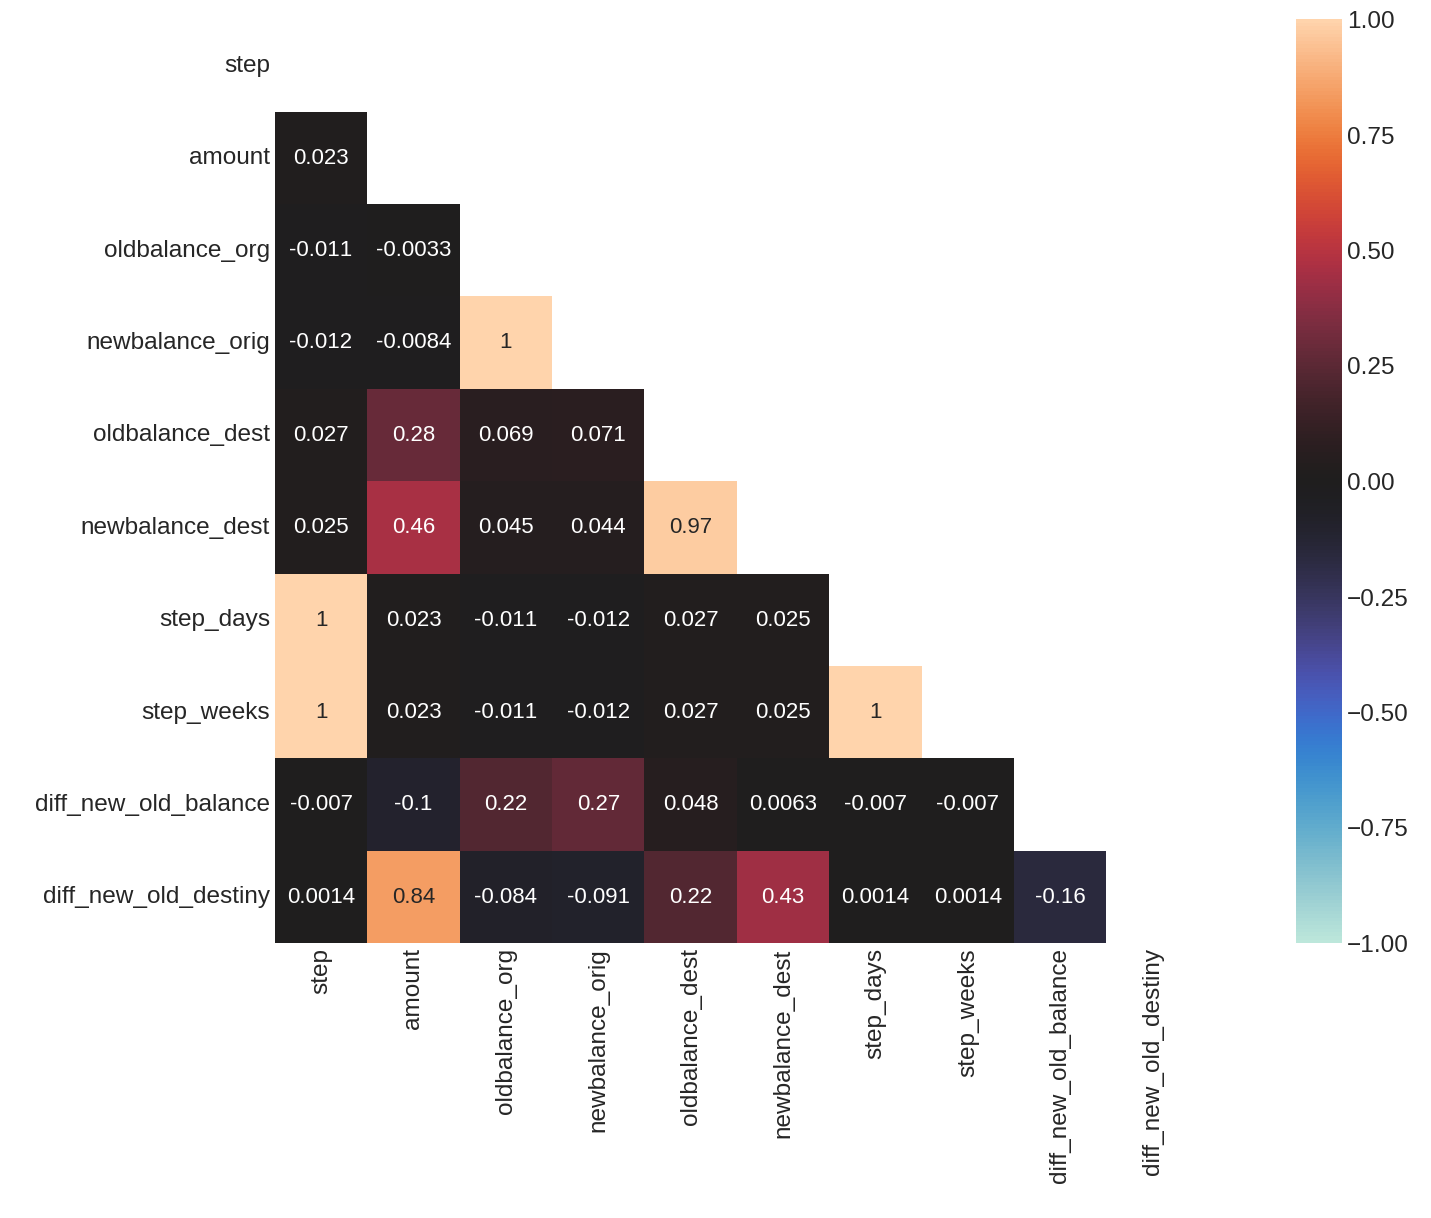

In [38]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2 Categorical Variables





In [39]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}

    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

corr = pd.DataFrame(dict_corr)

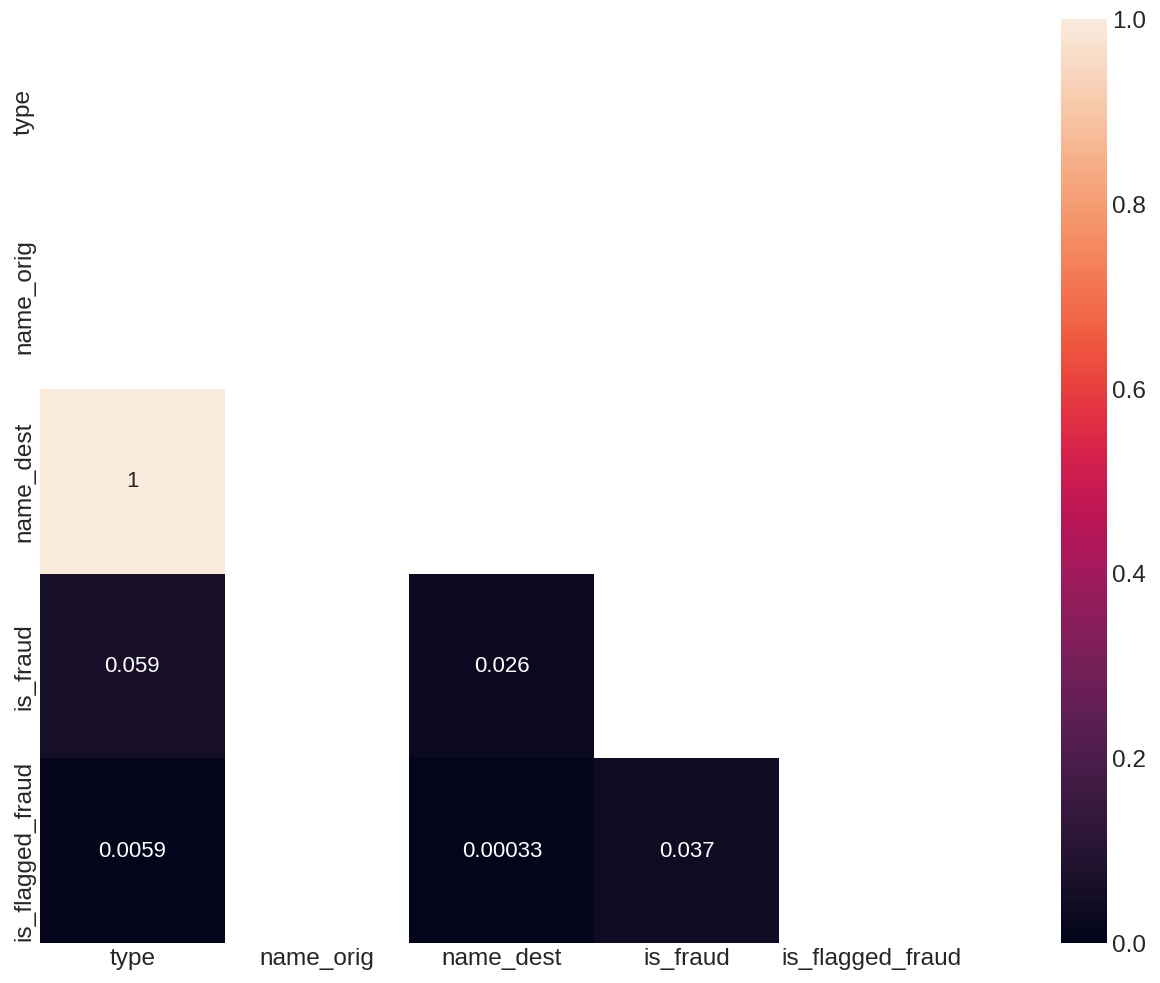

In [40]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

In [41]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [42]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [43]:
X.head()

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,diff_new_old_balance,diff_new_old_destiny
0,283,CASH_IN,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,210329.85,-210329.84
1,132,CASH_OUT,215489.19,21518.00,0.00,6345756.55,6794954.89,-21518.00,449198.34
2,355,DEBIT,4431.05,20674.00,16242.95,80876.56,85307.61,-4431.05,4431.05
3,135,CASH_OUT,214026.20,46909.73,0.00,13467450.36,13681476.56,-46909.73,214026.20
4,381,CASH_OUT,8858.45,0.00,0.00,1667180.58,1676039.03,0.00,8858.45


In [44]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [45]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [46]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [47]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

## 5.3 Rescaling

In [48]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 6.0 Feature Selection

## 6.1 Boruta




In [49]:
# # Assuming X_params and y_temp are your feature and target variables
# X_boruta = X_params.values
# y_boruta = y_temp.values.ravel()

In [50]:
# # Initialize BorutaPy with RandomForestClassifier
# boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

### 6.1.1 Best Features




In [51]:
# cols_selected_boruta = boruta.support_.tolist()

In [52]:
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [53]:
# columns_selected

# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_destiny',
#  'type_TRANSFER']

In [54]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

# 7.0 Machine Learning Modeling

In [55]:
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 7.1 Baseline

In [56]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [57]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 7.1.1 Classification Report

In [58]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.1.2 Cross Validation

In [59]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [60]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [61]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.58,1.0,0.16,0.276,0.276


### 7.2.1 Classification Report

In [62]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.16      0.28       131

    accuracy                           1.00    101802
   macro avg       1.00      0.58      0.64    101802
weighted avg       1.00      1.00      1.00    101802



### 7.2.2 Cross Validation

In [63]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(),
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041


## 7.3 K Nearest Neighbors

In [64]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [65]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.565,1.0,0.13,0.23,0.23


### 7.3.1 Classification Report

In [66]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.13      0.23       131

    accuracy                           1.00    101802
   macro avg       1.00      0.56      0.61    101802
weighted avg       1.00      1.00      1.00    101802



### 7.3.2 Cross Validation

In [67]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(),
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038


## 7.4 Support Vector Machine

In [68]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [69]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### 7.4.1 Classification Report

In [70]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.4.2 Cross Validation

In [71]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047


## 7.5 Random Forest

In [72]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [73]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.844,0.978,0.687,0.807,0.807


### 7.5.1 Classification Report

In [74]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.98      0.69      0.81       131

    accuracy                           1.00    101802
   macro avg       0.99      0.84      0.90    101802
weighted avg       1.00      1.00      1.00    101802



### 7.5.2 Cross Validation

In [75]:
rf_cv = ml_cv_results('Random Forest',
                      RandomForestClassifier(),
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029


## 7.6 XGBoost

In [76]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [77]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.874,0.942,0.748,0.834,0.834


### 7.6.1 Classification Report

In [78]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.94      0.75      0.83       131

    accuracy                           1.00    101802
   macro avg       0.97      0.87      0.92    101802
weighted avg       1.00      1.00      1.00    101802



### 7.6.2 Cross Validation

In [79]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.887 +/- 0.021,0.938 +/- 0.017,0.775 +/- 0.042,0.848 +/- 0.023,0.848 +/- 0.023


## 7.7 LightGBM

In [80]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [81]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.625,0.009,0.29,0.018,0.016


### 7.7.1 Classification Report

In [82]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    101671
           1       0.01      0.29      0.02       131

    accuracy                           0.96    101802
   macro avg       0.50      0.63      0.50    101802
weighted avg       1.00      0.96      0.98    101802



### 7.7.2 Cross Validation

In [83]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(),
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.696 +/- 0.08,0.251 +/- 0.167,0.394 +/- 0.158,0.299 +/- 0.175,0.297 +/- 0.175


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [84]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results,
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.625,0.009,0.290,0.018,0.016
K Nearest Neighbors,0.565,1.000,0.130,0.230,0.230
Logistic Regression,0.580,1.000,0.160,0.276,0.276
Random Forest,0.844,0.978,0.687,0.807,0.807
XGBoost,0.874,0.942,0.748,0.834,0.834


### 7.8.2 Cross Validation Performance

In [85]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv,
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.565 +/- 0.013,1.0 +/- 0.0,0.129 +/- 0.026,0.228 +/- 0.041,0.228 +/- 0.041
LightGDM,0.696 +/- 0.08,0.251 +/- 0.167,0.394 +/- 0.158,0.299 +/- 0.175,0.297 +/- 0.175
SVM,0.596 +/- 0.017,1.0 +/- 0.0,0.192 +/- 0.034,0.32 +/- 0.047,0.32 +/- 0.047
K Nearest Neighbors,0.705 +/- 0.017,0.943 +/- 0.033,0.411 +/- 0.034,0.572 +/- 0.038,0.572 +/- 0.038
Random Forest,0.861 +/- 0.019,0.969 +/- 0.018,0.721 +/- 0.038,0.827 +/- 0.029,0.827 +/- 0.029
XGBoost,0.887 +/- 0.021,0.938 +/- 0.017,0.775 +/- 0.042,0.848 +/- 0.023,0.848 +/- 0.023


# 8.0 Hyperparameter Fine Tuning

In [86]:
f1 = make_scorer(f1_score)

In [87]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [89]:
gs = GridSearchCV(XGBClassifier(),
                  param_grid=params,
                  scoring=f1,
                  cv=StratifiedKFold(n_splits=2))

gs.fit(X_params_cs, y_temp)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.3, 0.1, 0.01],
                         'scale_pos_weight': [1, 774, 508, 99]},
             scoring=make_scorer(f1_score))

In [90]:
best_params = gs.best_params_
best_params

{'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [91]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [92]:
gs.best_score_

0.8366920241920243

## 8.1 Results

In [93]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [94]:
xgb_gs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [95]:
y_pred = xgb_gs.predict(X_valid_cs)

### 8.1.2 Single Results

In [96]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.874,0.942,0.748,0.834,0.834


### 8.1.3 Cross Validation

In [97]:
xgb_gs_cv = ml_cv_results('XGBoost GS', xgb_gs, X_temp_cs, y_temp)
xgb_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.877 +/- 0.01,0.943 +/- 0.018,0.753 +/- 0.02,0.837 +/- 0.018,0.837 +/- 0.018


#9.0 Conclusions

## 9.1 Final Model

In [98]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### 9.1.1 Unseen Data Score

In [99]:
y_pred = final_model.predict(X_test_cs)

In [100]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.912,0.957,0.823,0.885,0.885


## 9.2 Blocker Fraud Company Expansion

### 9.2.1 The company receives 25% of each transaction value truly detected as fraud.

In [101]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [102]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

In [103]:
print('The company can receive %.2f detecting fraud transactions.' % (receives))

The company can receive 60638881.09 detecting fraud transactions.


### 9.2.2 The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.

In [104]:
aux1 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('For wrong decisions, the company can receive %.2f.' % (receives))

For wrong decisions, the company can receive 108137.29.


### 9.2.3 The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [105]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
receives = aux1['amount'].sum()

print('However, the company must return the amount of %.2f.' % (receives))

However, the company must return the amount of 3445682.59.


## 9.3 Model's Performance

### 9.3.1 What is the model's Precision and Accuracy?

In [106]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.91 and precision is equal 0.96.


### 9.3.2 How reliable is the model in classifying transactions as legitimate or fraudulent?

In [1]:
print('The model can detect 0.837 +/- 0.018 of the fraud. However it detected 0.885 of the frauds from a unseen data.')

The model can detect 0.837 +/- 0.018 of the fraud. However it detected 0.885 of the frauds from a unseen data.


### 9.3.3 What is the revenue expected by the company  classify 100% of transactions with the model?

In [108]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

aux2 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can revenue %.2f.' % (receives + receives2))

Using the model the company can revenue 60747018.38.


In [109]:
aux3 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives = aux3['amount'].sum() * 0.25

aux4 = df_test[(df_test['is_fraud'] == 'no') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives2 = aux4['amount'].sum() * 0.05

print('However the currently method the revenue is %.2f.' % (curr_receives + curr_receives2))

However the currently method the revenue is 0.00.


### 9.3.4 What is the loss expected by the Company if it classifies 100% of the transactions with the model?

In [110]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['amount'].sum()

print('For wrong classifications the company must return the amount of %.2f.' % (loss))

For wrong classifications the company must return the amount of 3445682.59.


In [111]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'no')]
curr_loss = aux1['amount'].sum()

print('For wrong classifications using the currently method, the company must return the amount of %.2f.' % (curr_loss))

For wrong classifications using the currently method, the company must return the amount of 246001206.94.


### 9.3.5 What is the profit expected by the blocker fraud company when using the model?

In [112]:
print('The company can expect the profit of %.2f.' % (receives + receives2 - loss))

The company can expect the profit of 57301335.79.


In [113]:
print('Using the currently method, the profit is %.2f.' % (curr_receives + curr_receives - curr_loss))

Using the currently method, the profit is -246001206.94.
